In [7]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

from RPCA import RPCA, RPCA_partial

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
indices_3 = mnist.target[mnist.target == '3'].keys()
mnist_3 = mnist.data.iloc[indices_3].to_numpy()

In [4]:
indices_6 = mnist.target[mnist.target == '6'].keys()
mnist_6 = mnist.data.iloc[indices_6].to_numpy()

In [5]:
mnist_sample = mnist_3[:100]

In [8]:
# %%timeit

X = mnist_sample
L,S = RPCA_partial(X, rank=1)

In [28]:
def plt_mnist(image): return plt.imshow(image.reshape(28,28),cmap=plt.cm.gray_r)

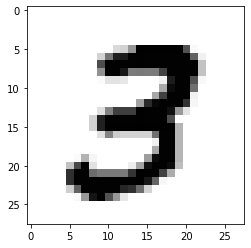

In [11]:
plt_mnist(X[0])

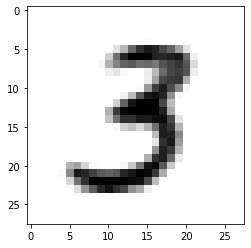

In [12]:
plt_mnist(L[0].round(3))

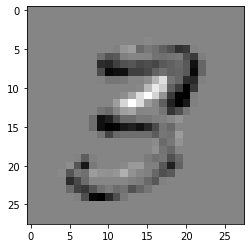

In [13]:
plt_mnist(S[0].round())

In [29]:
def mnist_subplots(X):

    plt.figure(figsize=(5, 20))

    # set number of columns (use 3 to demonstrate the change)
    ncols = 5
    # calculate number of rows
    nrows = len(X) // ncols + (len(X) % ncols > 0)

    # loop through the length of tickers and keep track of index
    for i, x in enumerate(X):
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, i + 1)
        ax.tick_params(
            bottom=False,
            left=False,
            labelbottom=False,
            labelleft=False
        )
        
        # filter df and plot ticker on the new subplot axis
        plt_mnist(x)

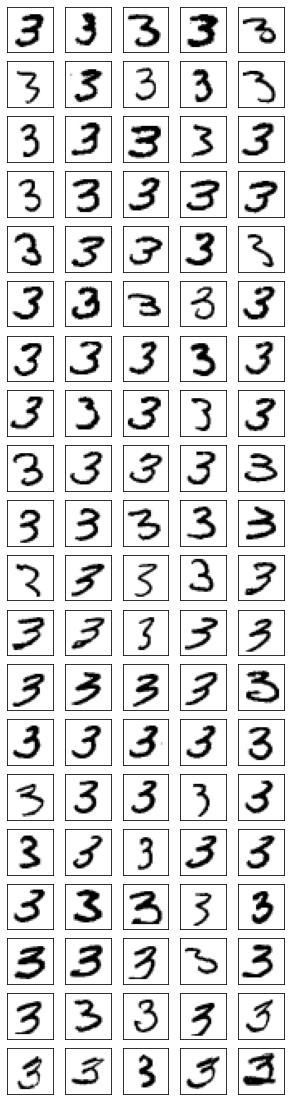

In [12]:
mnist_subplots(X)

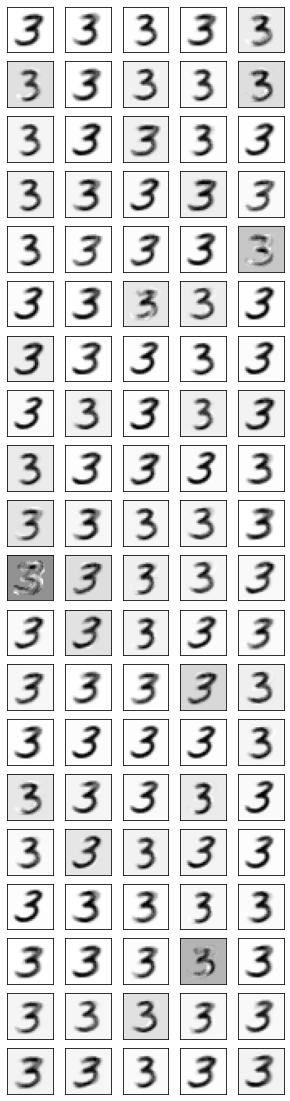

In [13]:
mnist_subplots(L)

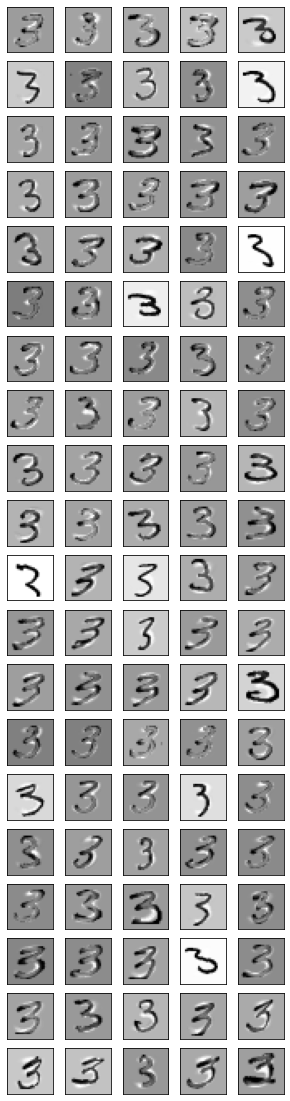

In [14]:
mnist_subplots(S)

In [15]:
print(np.linalg.matrix_rank(X))
print(np.linalg.matrix_rank(L))
print(np.linalg.matrix_rank(S))

100
15
100


#### Next steps
Test PCA on same sample and see how much variance the first 15 components account for

Add progressively more random noise to corrupt X and see how RPCA performs

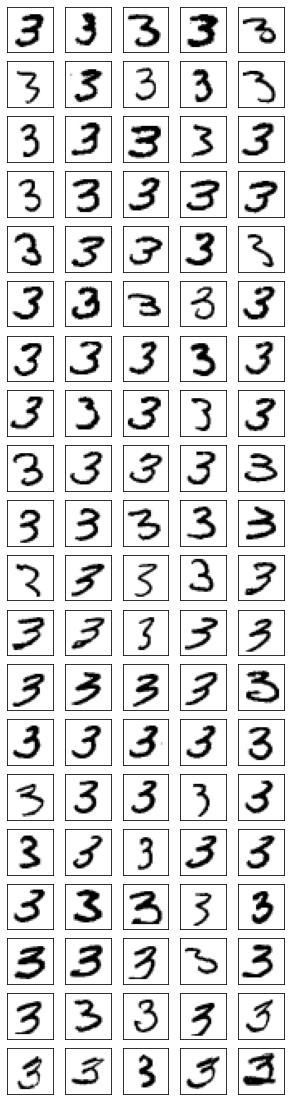

In [19]:
mnist_subplots(mnist_sample)

In [22]:
mnist_sample.shape

(100, 784)

In [73]:
corruption = np.random.gamma(1,4,(100,784))
mnist_corrupted = mnist_sample + ((corruption > 5) * corruption)*25
mnist_corrupted

array([[  0.        ,   0.        ,   0.        , ..., 200.99435599,
          0.        ,   0.        ],
       [197.29819335, 197.9748662 ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 310.00844325, ..., 139.88176873,
          0.        ,   0.        ],
       ...,
       [149.79461027,   0.        ,   0.        , ..., 357.70880184,
          0.        ,   0.        ],
       [354.14032257,   0.        ,   0.        , ...,   0.        ,
          0.        , 351.61199165],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        165.63542351, 463.43562573]])

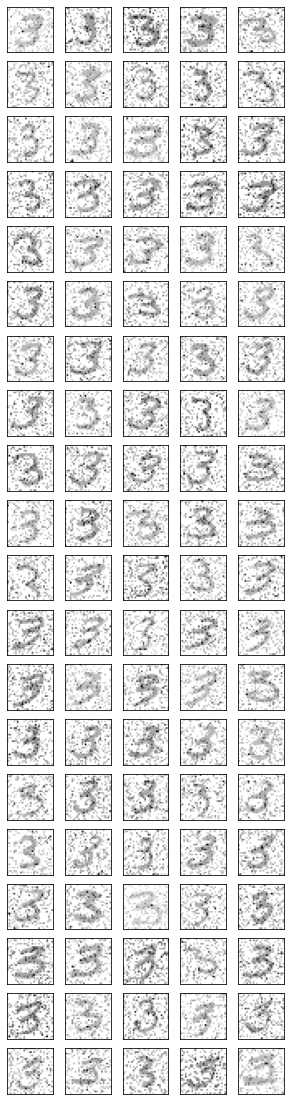

In [74]:
mnist_subplots(mnist_corrupted)

In [75]:
X_c = mnist_corrupted
L_c,S_c = RPCA(X_c)

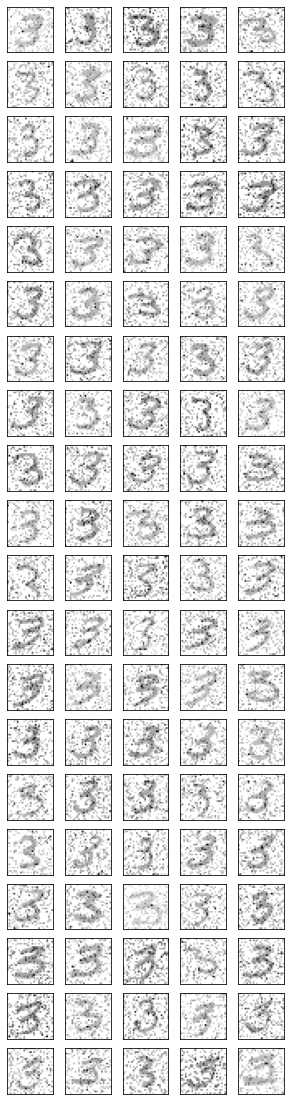

In [76]:
mnist_subplots(X_c)

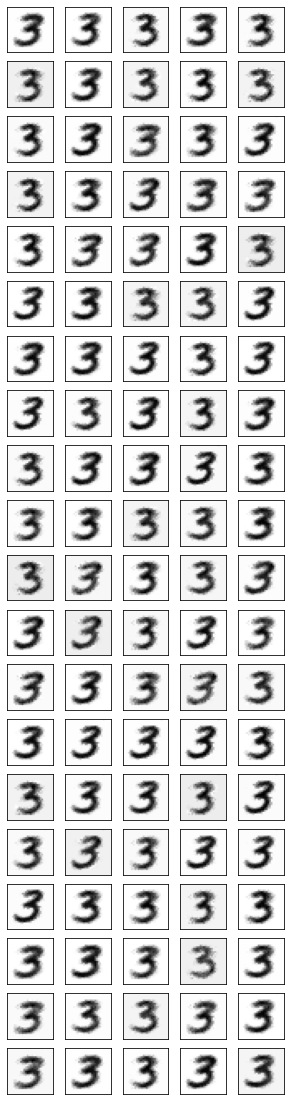

In [77]:
mnist_subplots(L_c)

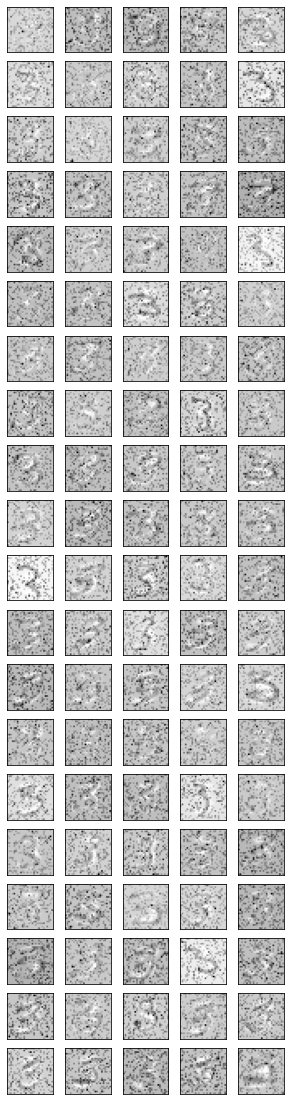

In [78]:
mnist_subplots(S_c)

In [80]:
np.linalg.matrix_rank(L_c)

15

In [102]:
def RPCA_stop(X, stop_count=1000):
    
    def shrink(X,tau):
        Y = np.abs(X)-tau
        return np.sign(X) * np.maximum(Y,np.zeros_like(Y))
    
    def SVT(X,tau):
        U,S,VT = np.linalg.svd(X,full_matrices=0)
        out = U @ np.diag(shrink(S,tau)) @ VT
        return out
    
    n1,n2 = X.shape
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n1,n2))
    thresh = 10**(-7) * np.linalg.norm(X)
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    while (np.linalg.norm(X-L-S) > thresh) and (count < stop_count):
        L = SVT(X-S+(1/mu)*Y,1/mu)
        # mnist_subplots(L)
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        # mnist_subplots(S)
        Y = Y + mu*(X-L-S)
        # mnist_subplots(Y)
        count += 1
        
    return L,S,Y

In [107]:
L_stop, S_stop, Y_stop = RPCA_stop(X, 500)

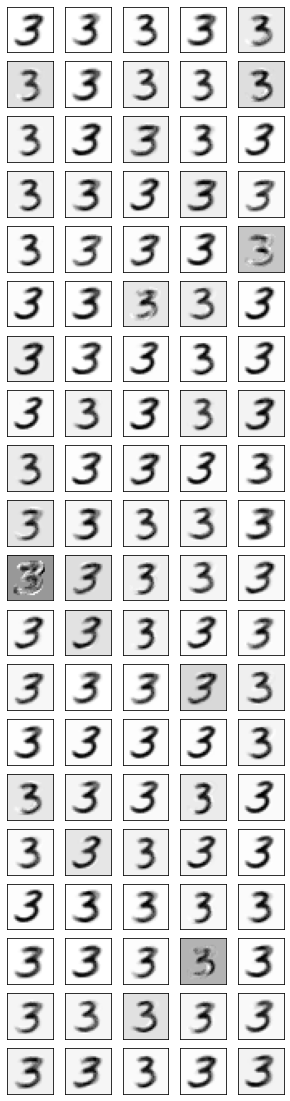

In [108]:
mnist_subplots(L_stop)

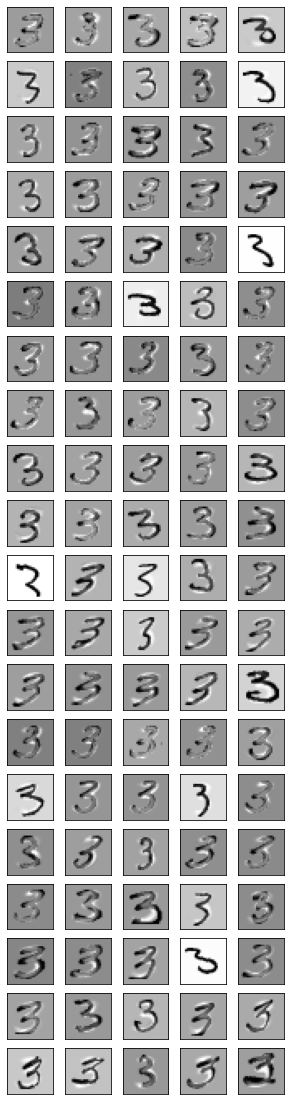

In [109]:
mnist_subplots(S_stop)

In [115]:
np.max(Y_stop)

0.03571428571428595

In [6]:
mnist_sample.shape

(100, 784)

In [14]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA()
pca.fit(mnist_sample)

PCA()

In [23]:
np.cumsum(pca.explained_variance_ratio_)[15]

0.7388040863383465

In [32]:
pca_15 = PCA(n_components=15).fit(mnist_sample)

In [33]:
pc_15 = pca_15.transform(mnist_sample)
mnist_pca_15 = pca_15.inverse_transform(pc_15)

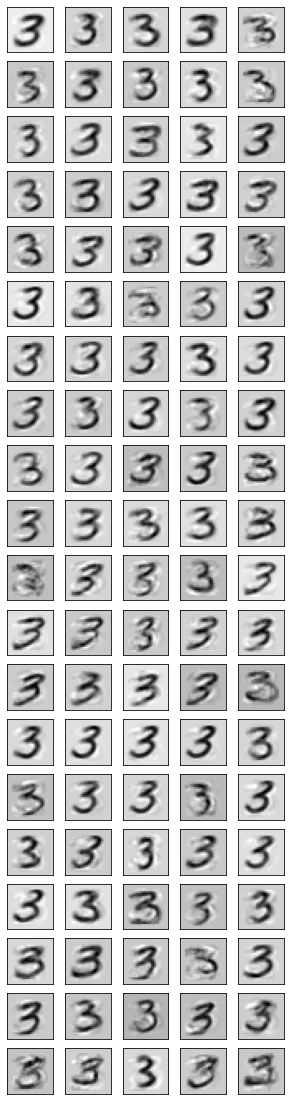

In [34]:
mnist_subplots(mnist_pca_15)